In [61]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, Embedding, GRU, SimpleRNN, LSTMCell, BatchNormalization, RNN

## 내장 RNN레이어

In [5]:
model = keras.Sequential()
# input vocab of size 1000
model.add(layers.Embedding(input_dim = 1000, output_dim = 64))
# 128 internal units
model.add(layers.LSTM(128))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


## 출력과 상태
- `return_sequences=True`를 설정하면 RNN 레이어가 각 샘플(샘플 및 타임스텝당 하나의 벡터)에 대한 전체 출력 시퀀스도 반환 가능

In [7]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim = 1000, output_dim = 64))
# output_dim will be a 3D Tensor >> (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences = True))
# output_dim will be a 2D Tensor >> (batch_size, 128)
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


1.
- 최종 내부 상태를 반환 할 수 있음, 나중에 RNN 실행을 재개하거나 다른 RNN을 초기화하는데 사용될 수 있다
- 이 설정은 인코더의 최종 상태가 디코더의 초기 상태로 사용되는 인코더-디코더 시퀀스-시퀀스 모델에서 일반적으로 사용됩니다
2.
- 내부 상태를 반환하도록 RNN레이어를 구성하려면 레이어를 생성할 때, `return_state` 매개변수를 `True`로 설정한다.
- 참고로 `LSTM`에는 두 개의 상태 텐서가 있지만 `GRU`에는 하나만 있다
3.
- 레이어의 초기 상태를 구성하려면 추가 키워드 인수 `initial_state`로 레이어를 호출하면 된다.]
- 상태의 형상은 아래 예와 같이 레이어의 단위 크기와 일치해야한다.

In [9]:
ENCODER_VOCAB = 1000
DECODER_VOCAB = 2000

encoder_input = layers.Input(shape = (None, ))
encoder_embedded = layers.Embedding(input_dim = ENCODER_VOCAB, output_dim = 64)(encoder_input)

# output에 내부 상태 반환시키기 ( return_state )
output, state_h, state_c = layers.LSTM(64, return_state = True, name = 'Encoder')(encoder_embedded)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape = (None, ))
decoder_embedded = layers.Embedding(input_dim = DECODER_VOCAB, output_dim = 64)(decoder_input)

# 새로운 LSTM레이어에 두개의 state를 통과시키자
decoder_output = layers.LSTM(64, name = 'Decoder')(decoder_embedded, initial_state = encoder_state)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 64)     64000       ['input_2[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, None, 64)     128000      ['input_3[0][0]']                
                                                                                              

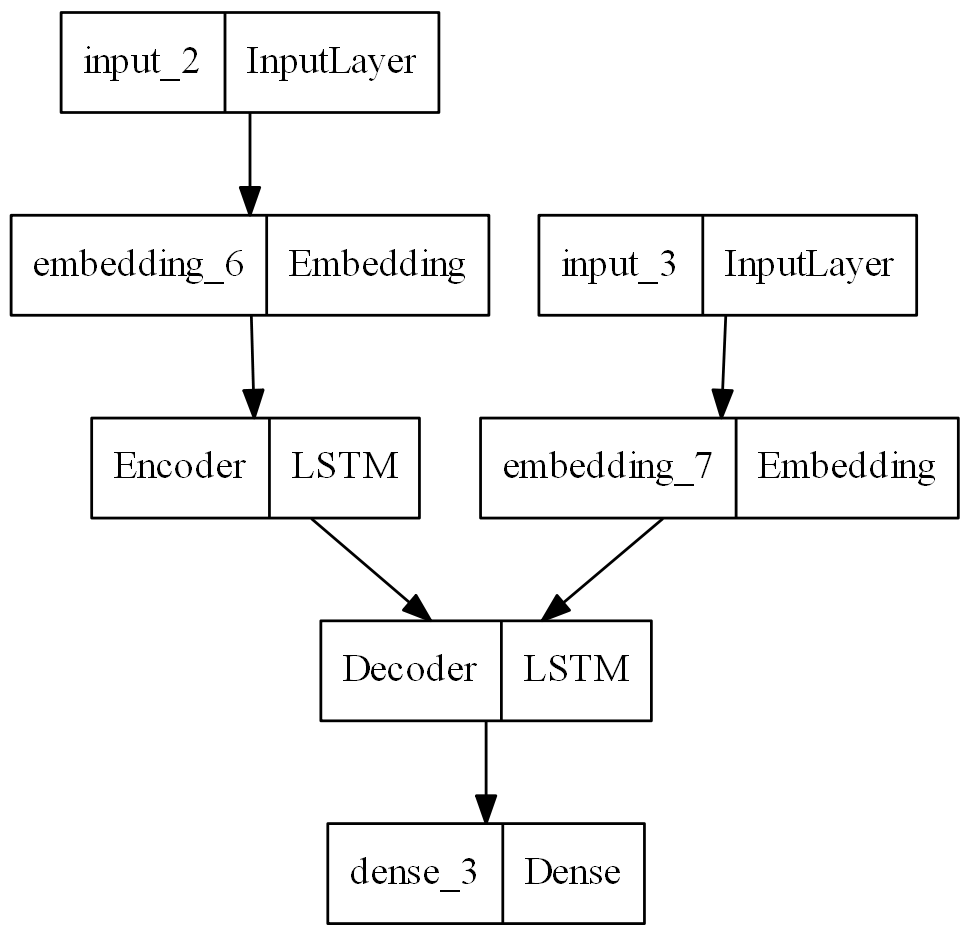

In [14]:
plot_model(model, dpi = 200, to_file = 'RNN_basic.png')

## RNN레이어 및 RNN셀
- 입력 시퀀스의 전체 배치를 처리하는 RNN레이어와 달리 RNN셀은 단일 타임스텝만 처리한다
- 

## 크로스배치 상태 저장
- 무한할 수도 있는 매우 긴 시퀀스를 처리할 때 크로스 배치 상태 저장 패턴을 사용할 수 있다
- 시퀀스가 매우 긴 경우, 시퀀스를 더 짧은 시퀀스로 나눈 다음 레이어의 상태를 재설정하지 않고 이 짧은 시퀀스를 RNN 레이어에 순차적으로 공급하는 것이 좋다
- 이렇게 하면 레이어가 한 번에 하나의 하위 시퀀스만 받더라도 시퀀스 전체에 대한 정보를 유지할 수 있다
- 생성자에서 `stateful = True`를 설정하여 이 작업을 수행 할 수 있다

In [15]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful = True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# 'reset_state()'는 original initial_state에 축적되어있는 상태를 reset할 것
# 만약 initial_state가 제공되지않는다면, zero-state가 default 값임
lstm_layer.reset_states()

## RNN상태 재사용
- RNN레이어의 기록된 상태는 `layer.weights()`에 포함되지 않는다. 재사용하려면 `layers.state`로 상태 값을 가져오고 `new_layer(inputs, initial_state = layer.state)` 또는 모델 하위 클래싱과 같은 Keras functional API를 통해 이를 새 레이어의 초기 상태로 사용 할 수 있다

- 순차 모델은 하나의 입력 및 출력이 있는 레이어만 지원하여 초기 상태가 추가로 입력되면 사용이 불가능하므로 이 경우에 사용할 수 없다
- weights값 불러오기 느낌

In [19]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful = True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

# paragraph1, paragraph2에 담긴 정보를 'existing_state'에 담고
existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
# 'existing_state'로부터 시작하는 레이어를 하나 더 만들기
new_output = new_lstm_layer(paragraph3, initial_state = existing_state)

## 양방향 RNN
- 시계열 이외의 시퀀스(예: 텍스트)의 경우, RNN 모델이 시퀀스를 처음부터 끝까지 처리할 뿐만 아니라 ***역방향***으로도 처리하면 성능이 더 좋아지는 경우가 종종 있니다
- 예를들어, 문장에서 다음 단어를 예측하려면 단어 앞에 오는 단어뿐만 아니라 단어 주변의 컨텍스트까지 있으면 유용한 경우가 많다

- Keras는 `keras.layers.Bidirectional` wrapper와 같은 이러한 **양방향RNN**을 쉽게 구축할 수 있는 API를 제공한다

In [25]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences = True), input_shape = (5, 10)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(10))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           38400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


`Bidirectional`은 전달된 RNN 레이어를 복사하고 새로 복사된 레이어의 `go_backwards` 필드를 뒤집어 입력을 역순으로 처리한다
`Bidirectional` RNN의 출력은 기본적으로, 정뱡향 레이어 출력과 역방향 레이어 출력이 합산된 것입니다. 연결과 같은 다른 병합 동작이 필요한 경우 `Bidirectional` wrapper 생성자에서 `merge_mode` 매개변수를 변경합니다

## CuDNN 커널 사용
- Mnist데이터를 통해 LSTM과 CuDNN 커널을 사용했을때의 성능 차이를 확인해보자

In [29]:
BATCH_SIZE = 64
# Mnist's shape => Tensor of shape (batch_size, 28, 28)
INPUT_DIM = 28
UNITS = 64
# class는 10가지임
OUTPUT_SIZE = 10

In [62]:
def build_model(allow_cudnn_kernel = True):
    # CuDNN은 layer단위에서만 사용가능하며, cell단위에선 불가
    # 즉, 'LSTM(units)' 는 CuDNN kernel을 사용할것임 ( 사용o )
    # 반면에 RNN(LSTMCell(units))은 non-CuDNN kernel 상태일것임 ( 사용x )
    if allow_cudnn_kernel:
        # LSTM의 default값이 CuDNN사용
        lstm_layer = LSTM(UNITS, input_shape = (None, INPUT_DIM))
    else:
        # 래핑된 RNN layer안에서의 LSTMCell은 CuDNN 사용불가
        lstm_layer = RNN(
            LSTMCell(UNITS), input_shape = (None, INPUT_DIM))
    
    model = Sequential([
        lstm_layer,
        BatchNormalization(),
        Dense(OUTPUT_SIZE)
    ])
    
    return model

In [63]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

* loss `sparse_categorical_crossentropy`
* 모델의 목표는 정수 벡터이고 각 정수는 0에서 9 사이의 범위에 있다

In [64]:
model = build_model(allow_cudnn_kernel = True)

In [65]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'sgd',
              metrics = ['acc']
             )

hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = BATCH_SIZE, epochs = 1)

938/938 [==============================] - 5s 5ms/step - loss: 0.9170 - acc: 0.7121 - val_loss: 0.6298 - val_acc: 0.7860


In [66]:
noncudnn_model = build_model(allow_cudnn_kernel = False)
noncudnn_model.set_weights(model.get_weights())

noncudnn_model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                      optimizer = 'sgd',
                      metrics = ['acc'])

noncudnn_model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = BATCH_SIZE, epochs = 1)

938/938 [==============================] - 55s 58ms/step - loss: 0.3760 - acc: 0.8877 - val_loss: 0.2540 - val_acc: 0.9224


Predicted result is: [7], target result is: 5


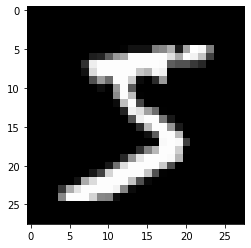

In [67]:
import matplotlib.pyplot as plt

model = build_model(allow_cudnn_kernel = True)
model.set_weights(model.get_weights())
result = tf.argmax(model.predict_on_batch(tf.expand_dims(sample, 0)), axis = 1)
print("Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label))
plt.imshow(sample, cmap = plt.get_cmap("gray"))

# 예제

## Module Import

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, RNN, LSTM, SimpleRNN, Dropout

## 데이터
- 동산 개별 실거래가는 매달에 맞춰 거래가 일어나지 않기 때문에 일단 한국감정원에서 배포하는 전국주택가격지수 중에서 강남구의 아파트 거래가격 지수를 사용

In [176]:
#!pip install finance-datareader

In [177]:
import FinanceDataReader as fdr

In [178]:
samsung = fdr.DataReader('005930')

In [179]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-11-25,75100,75100,73600,73700,12559258,-0.014706
2021-11-26,73500,74100,72000,72300,13002242,-0.018996
2021-11-29,71700,73000,71400,72300,16682559,0.000000
2021-11-30,73200,73900,70500,71300,30364841,-0.013831
2021-12-01,72000,74800,71600,74300,18459042,0.042076


In [249]:
teslr = fdr.DataReader('TSLA')

In [250]:
teslr.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2010-06-30,4.77,5.16,6.08,4.66,85970000.0,-0.0021
2010-07-01,4.39,5.00,5.18,4.05,41150000.0,-0.0797
2010-07-02,3.84,4.60,4.62,3.74,25710000.0,-0.1253
2010-07-06,3.22,4.00,4.00,3.17,34400000.0,-0.1615
2010-07-07,3.16,3.28,3.33,3.00,34620000.0,-0.0186


In [251]:
teslr.index

DatetimeIndex(['2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
               '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13', '2010-07-14',
               ...
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23', '2021-11-24', '2021-11-26',
               '2021-11-29', '2021-11-30'],
              dtype='datetime64[ns]', name='Date', length=2877, freq=None)

In [252]:
## 월별, 연도별로 구분해주기

teslr['Year'] = teslr.index.year
teslr['Month'] = teslr.index.month
teslr['Day'] = teslr.index.day

In [253]:
teslr.head()

,Close,Open,High,Low,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2010-06-30,4.77,5.16,6.08,4.66,85970000.0,-0.0021,2010,6,30
2010-07-01,4.39,5.00,5.18,4.05,41150000.0,-0.0797,2010,7,1
2010-07-02,3.84,4.60,4.62,3.74,25710000.0,-0.1253,2010,7,2
2010-07-06,3.22,4.00,4.00,3.17,34400000.0,-0.1615,2010,7,6
2010-07-07,3.16,3.28,3.33,3.00,34620000.0,-0.0186,2010,7,7


Text(0, 0.5, 'price')

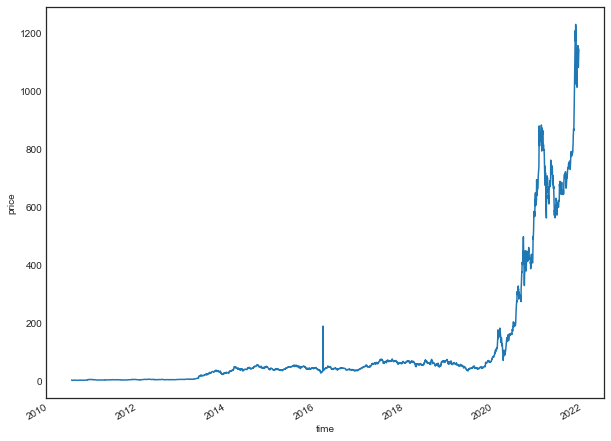

In [254]:
plt.figure(figsize = (10, 8))

teslr['Close'].plot()
plt.xlabel('time')
plt.ylabel('price')

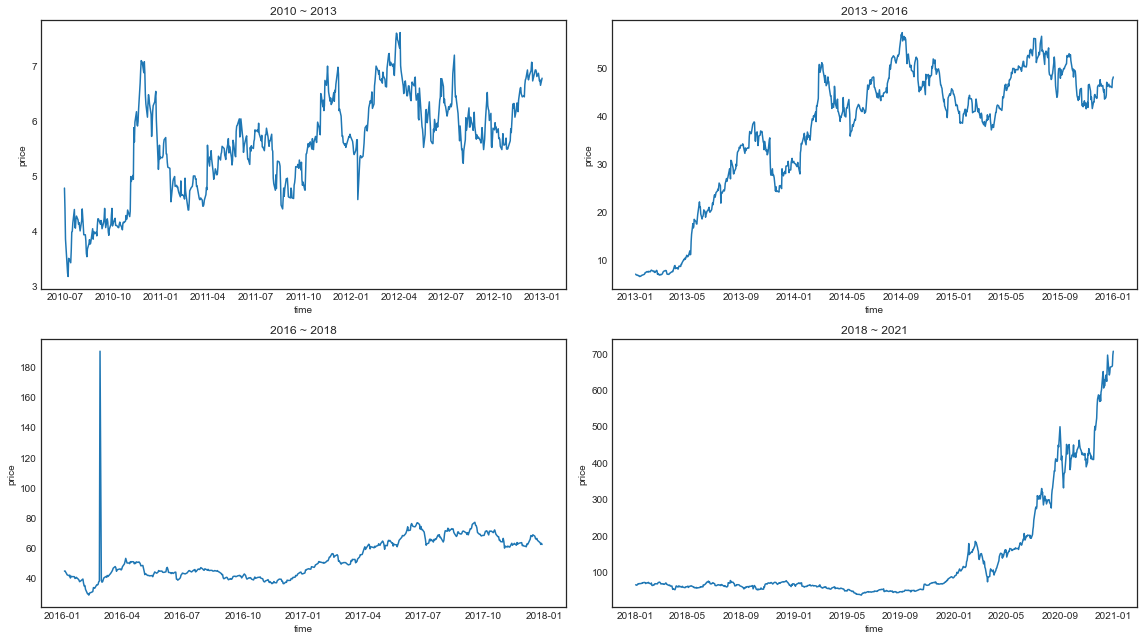

In [255]:
time_step = [['2010', '2013'],
            ['2013', '2016'],
            ['2016', '2018'],
            ['2018', '2021']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)

for i in range(4):
    ax = axes[i//2, i%2]
    df = teslr.loc[(teslr.index > time_step[i][0]) & (teslr.index < time_step[i][1])]
    sns.lineplot(y = df['Close'], x = df.index, ax = ax)
    ax.set_title(f'{time_step[i][0]} ~ {time_step[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    
plt.tight_layout()
plt.show()

In [256]:
## 전처리

scaler = MinMaxScaler()
# 스케일할 column 정의
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후, column
scaled = scaler.fit_transform(teslr[scale_cols])
scaled

array([[1.56760181e-03, 2.21745581e-03, 1.36738056e-03, 1.31241084e-03,
        2.80755646e-01],
       [1.43764519e-03, 1.49174300e-03, 8.64909390e-04, 1.00264928e-03,
        1.33368430e-01],
       [1.11275362e-03, 1.04018836e-03, 6.09555189e-04, 5.54310169e-04,
        8.25951449e-02],
       ...,
       [8.90397830e-01, 8.91376919e-01, 8.87973641e-01, 8.79364174e-01,
        3.64256555e-02],
       [8.91632418e-01, 9.18704038e-01, 9.03780890e-01, 9.24255146e-01,
        6.11546128e-02],
       [9.26866908e-01, 9.39128822e-01, 9.18451400e-01, 9.30588955e-01,
        8.52258850e-02]])

In [257]:
## 새로운 데이터프레임 정의

df = pd.DataFrame(scaled, columns = scale_cols)
df

,Open,High,Low,Close,Volume
0,0.001568,0.002217,0.001367,0.001312,0.280756
1,0.001438,0.001492,0.000865,0.001003,0.133368
2,0.001113,0.001040,0.000610,0.000554,0.082595
3,0.000625,0.000540,0.000140,0.000049,0.111172
4,0.000041,0.000000,0.000000,0.000000,0.111895
...,...,...,...,...,...
2872,0.945662,0.949208,0.872900,0.901463,0.116400
2873,0.874901,0.910721,0.872323,0.907145,0.072237
2874,0.890398,0.891377,0.887974,0.879364,0.036426
2875,0.891632,0.918704,0.903781,0.924255,0.061155


In [290]:
## train/test 분할

x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size = .2, random_state = 0, shuffle = False)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2301, 4) (2301,)
(576, 4) (576,)


C:\Users\User\AppData\Local\Temp/ipykernel_9980/297293286.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size = .2, random_state = 0, shuffle = False)


In [291]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [292]:
WINDOW_SIZE=20
BATCH_SIZE=32

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [293]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [294]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [295]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     61/Unknown - 1s 8ms/step - loss: 5.1652e-05 - mse: 1.0330e-04
Epoch 00001: val_loss improved from inf to 0.01244, saving model to tmp\ckeckpointer.ckpt
72/72 [==============================] - 2s 12ms/step - loss: 4.4678e-05 - mse: 8.9356e-05 - val_loss: 0.0124 - val_mse: 0.0249
Epoch 2/50
65/72 [==========================>...] - ETA: 0s - loss: 6.7720e-06 - mse: 1.3544e-05
Epoch 00002: val_loss improved from 0.01244 to 0.01191, saving model to tmp\ckeckpointer.ckpt
72/72 [==============================] - 0s 5ms/step - loss: 6.4782e-06 - mse: 1.2956e-05 - val_loss: 0.0119 - val_mse: 0.0238
Epoch 3/50
65/72 [==========================>...] - ETA: 0s - loss: 6.5713e-06 - mse: 1.3143e-05
Epoch 00003: val_loss did not improve from 0.01191
72/72 [==============================] - 0s 5ms/step - loss: 6.3176e-06 - mse: 1.2635e-05 - val_loss: 0.0120 - val_mse: 0.0240
Epoch 4/50
63/72 [=========================>....] - ETA: 0s - loss: 6.8089e-06 - mse: 1.3618e-05
Epoch 00004: v

In [296]:
model.load_weights(filename)

In [297]:
pred = model.predict(test_data)

In [298]:
pred.shape

(556, 1)

## 예측 데이터 시각화

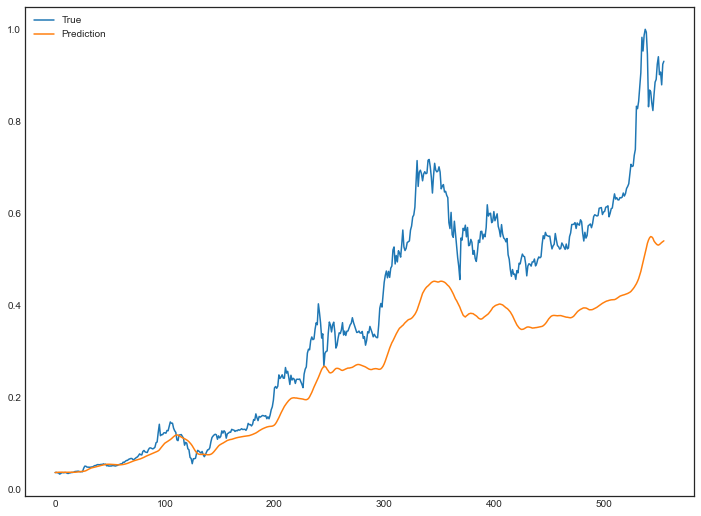

In [299]:
plt.figure(figsize = (12, 9))
plt.plot(np.array(y_test)[20:], label = 'True')
plt.plot(pred, label = 'Prediction')
plt.legend()
plt.show()

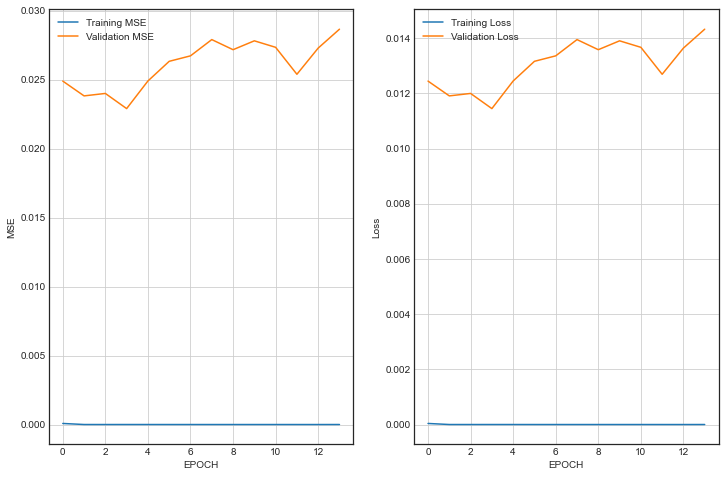

In [303]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['mse'], label = 'Training MSE')
plt.plot(history.history['val_mse'], label = 'Validation MSE')
plt.xlabel('EPOCH')
plt.ylabel('MSE')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()